In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import torch
from torch.nn import functional as F

from sklearn.metrics import auc
from neurovlm.metrics import recall_curve
from neurovlm.data import data_dir
from neurovlm.retrieval_resources import (
    _load_autoencoder, _load_masker, _proj_head_text_mse,
    _proj_head_image_infonce, _proj_head_text_infonce,
)

In [ ]:
# Load pre-trained models
masker = _load_masker()
# autoencoder = _load_autoencoder()
# proj_head = _proj_head_text_mse()
# proj_head_text = _proj_head_text_infonce()
# proj_head_image = _proj_head_image_infonce()
# autoencoder = _load_autoencoder()
autoencoder = torch.load(data_dir / "autoencoder.pt", weights_only=False, map_location="cpu")
proj_head = torch.load(data_dir / f"proj_head_text_mse.pt", weights_only=False, map_location="cpu")
proj_head_text = torch.load(data_dir / f"proj_head_text_infonce.pt", weights_only=False, map_location="cpu")
proj_head_image = torch.load(data_dir / f"proj_head_image_infonce.pt", weights_only=False, map_location="cpu")

# Load neurovault
neurovault_data = torch.load(
    data_dir / "neurovault.pt", weights_only=False
)
df_neuro, df_pubs, _, neuro_clust, _, _, text_emb = neurovault_data.values()

sim_mean = torch.zeros(len(df_pubs))
sim_mean_dec = torch.zeros(len(df_pubs))


latent_image = torch.zeros((len(df_pubs), 384))
latent_text = torch.zeros((len(df_pubs), 384))

latent_image_dec = torch.zeros((len(df_pubs), 384))
latent_text_dec = torch.zeros((len(df_pubs), 384))

for i, doi in enumerate(df_pubs["doi"]):
    with torch.no_grad():

        # Encoded image
        im = autoencoder.encoder(torch.from_numpy(
            neuro_clust[np.where(df_neuro["doi"] == doi)[0]] > 0
        ).to(torch.float32))

        # Decoder model
        tx = F.normalize(text_emb[i], dim=0, eps=1e-8)
        tx_proj = F.normalize(proj_head(tx), dim=0, eps=1e-8)
        latent_text_dec[i] = tx_proj

        sim = (im / im.norm(dim=1)[:, None]) @ tx_proj
        amax = np.argmax(sim)
        sim_mean_dec[i] = sim[amax]
        latent_image_dec[i] = im[amax]

        # Contrastive model
        tx = F.normalize(text_emb[i], dim=0, eps=1e-8)
        tx_proj = F.normalize(proj_head_text(tx), dim=0, eps=1e-8)
        im_proj = F.normalize(proj_head_image(im), dim=1, eps=1e-8)
        
        sim = im_proj @ tx_proj
        amax = np.argmax(sim)

        latent_text[i] = tx_proj
        latent_image[i] = im_proj[amax]

## Plot Results

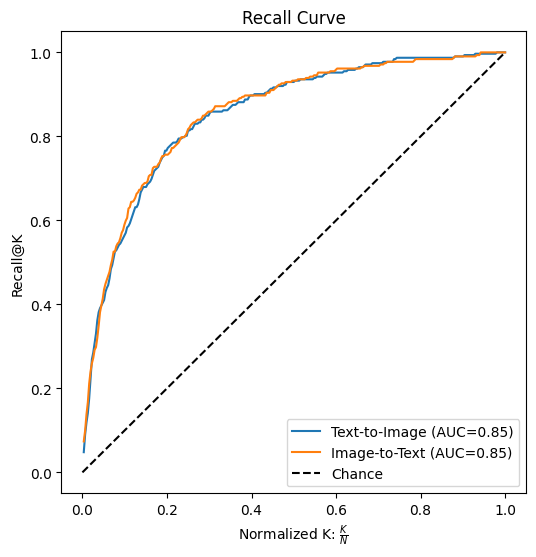

In [4]:
fig, ax = plt.subplots(figsize=(6, 6))

t_to_i, i_to_t = recall_curve(latent_text, latent_image)
x = np.arange(1, len(t_to_i)+1) / len(t_to_i)
ax.plot(x, t_to_i, label=f"Text-to-Image (AUC={round(auc(x, t_to_i), 2)})", color="C0")
ax.plot(x, i_to_t, label=f"Image-to-Text (AUC={round(auc(x, i_to_t), 2)})", color="C1")

ax.set_ylabel("Recall@K")
ax.set_xlabel(r"Normalized K: $\frac{K}{N}$")
ax.set_title("Recall Curve")
ax.plot([0, 1], [0, 1], color='k', ls='--', label="Chance")
ax.legend(loc="lower right")
plt.savefig(data_dir / "contrastive_recall.png", dpi=300)

## Brain-to-text Generation

In [ ]:
from neurovlm.train import which_device
from tqdm import tqdm
from math import ceil
from neurovlm.models import Specter
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from neurovlm.retrieval_resources import (
    _load_masker, _load_autoencoder, _load_networks
)
from nilearn.plotting import view_img

# Load from 10_n_grams.ipynb
concept_clf = torch.load(data_dir / "concept_clf.pt", weights_only=False)

# Load specter
specter = Specter("allenai/specter2_aug2023refresh", adapter="adhoc_query", device=which_device())

There are adapters available but none are activated for the forward pass.


In [6]:
# Load LLM
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_id, padding_side="left")

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

model.config.pad_token_id = tokenizer.pad_token_id

# Eval mode and disable gradients
model.eval()
for p in model.parameters():
    p.requires_grad_(False)
torch.set_grad_enabled(False)

torch.autograd.grad_mode.set_grad_enabled(mode=False)

In [10]:
system_prompt = """
You are a neuroscience editor writing a short wiki-style article from a list of terms.

INPUT: a list of neuroscience terms (networks, brain regions, cognitive functions, disorders).
OUTPUT: ONE article that uses the terms to form a coherent theme.

Rules:
1) Title (required): 6–12 words. Make it specific and content-based.
   - Use 1–2 of the most informative terms (prefer: network/circuit + region + cognition; add disorder only if strongly supported).
   - DO NOT use generic titles like: "Summary", "Overview", "Brain Network Analysis", "A Summary of Terms".

2) Lead paragraph (2–3 sentences):
   - State the unifying theme directly (what the terms collectively describe).
   - Name 3–5 “anchor” terms that drive the theme.
   - Do NOT say “the provided list”, “top-ranked”, “these terms appear”, or anything about scoring/ranking.

3) Body sections:
   - Networks
   - Key Regions
   - Cognitive Functions
   - Clinical Relevance

4) Be concrete:
   - Prefer specific mechanisms, pathways, and canonical associations over vague statements.
   - If a term is too vague/ambiguous/unrelated, ignore it in the main text.

No references. Do not mention this prompt.
""".strip()

In [24]:
# Load from 06_n_grams.ipynb
features = np.load(data_dir / "ngram_labels.npy")
mask = np.load(data_dir / "ngram_mask.npy")
df_neuro, df_pubs, _, _, _, _, _ = torch.load(data_dir / "neurovault.pt", weights_only=False).values()

# Concept predictions
logits = torch.sigmoid(concept_clf(latent_image_dec.to(which_device())).detach().cpu())
inds = logits.argsort(descending=True, dim=1).numpy()

# Prepare messages
messages = []
for i in range(len(logits)):
    user_prompt = ", ".join(features[inds[i, :50]])
    messages.append([
        {"role": "system", "content": system_prompt.strip("\n")},
        {"role": "user", "content": user_prompt},
    ])

In [26]:
import torch
from tqdm.notebook import tqdm
import pickle

torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision("high")  # safe speed win on Ampere+

def batch_generate(messages_batch, max_new_tokens=1000):
    # Convert chat messages -> strings once
    prompts = [
        tokenizer.apply_chat_template(m, tokenize=False, add_generation_prompt=True)
        for m in messages_batch
    ]
    enc = tokenizer(
        prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
    ).to(model.device)

    with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
        out = model.generate(
            **enc,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.2,
            top_p=0.95,
            top_k=50,
            repetition_penalty=1.1,
            use_cache=True,
        )

    # Decode
    gen = out[:, enc["input_ids"].shape[1]:]
    return tokenizer.batch_decode(gen, skip_special_tokens=True)

In [27]:
# Generate
batch_size = 16
summaries = []
for i in tqdm(range(0, len(messages), batch_size)):
    summaries.extend(batch_generate(messages[i:i+batch_size], max_new_tokens=1000))

# Save
with open(data_dir / "generated_summaries_neurovault.pkl", "wb") as f:
    pickle.dump(summaries, f)

  0%|          | 0/20 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

In [28]:
df_pubs["brain_to_text_summary"] = summaries
df_pubs.to_csv(data_dir / "neuro_vault_brain_to_text.csv", index=False)

In [2]:
from neurovlm.train import which_device
from tqdm import tqdm
from math import ceil
from neurovlm.models import Specter
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from neurovlm.retrieval_resources import (
    _load_masker, _load_autoencoder, _load_networks
)
from nilearn.plotting import view_img
import pandas as pd

# Load from 10_n_grams.ipynb
concept_clf = torch.load(data_dir / "concept_clf.pt", weights_only=False)

# Load specter
specter = Specter("allenai/specter2_aug2023refresh", adapter="adhoc_query", device=which_device())

There are adapters available but none are activated for the forward pass.


In [88]:
df_pubs = pd.read_csv(data_dir / "neuro_vault_brain_to_text.csv")

In [18]:
x = []
for i in df_pubs["brain_to_text_summary"]:
    j = i.split("\n")
    x.append(j[0] + "[SEP]" + " ".join(j[1:]))

with torch.no_grad():
    emb = specter(x)

In [ ]:
emb_proj = proj_head_text(F.normalize(emb.to("cpu"), dim=1))
cos_sim = F.normalize(emb_proj, dim=1) @ F.normalize(latent_image_dec, dim=1).T
cos_sim = cos_sim.detach().numpy()
idx = np.argsort(np.diag(cos_sim))[::-1]

In [102]:
df_pubs_sort = df_pubs.iloc[idx].reset_index(drop=True)
df_pubs_sort.to_csv(data_dir / "neuro_vault_brain_to_text_sorted.csv")